In [1]:
import nltk
nltk.download('stopwords')

from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas
import urllib.request
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
# text , headlines
data.sample(10)
# data.shape // (98401, 2)
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


## Step 2. 데이터 전처리하기 (추상적 요약)

In [3]:
#중복 샘플과 NULL 값이 존재하는 샘플 제거

## 중복확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
## null 값 확인 
print('data 중 null 취합 확인')
print(data.isnull().sum())

## text 열 기준 중복제거 
data.drop_duplicates(subset = ['text'], inplace=True)

print('남은 전체 샘플수 :', (len(data)))

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
data 중 null 취합 확인
headlines    0
text         0
dtype: int64
남은 전체 샘플수 : 98360


In [4]:
# 텍스트 정규화와 불용어 제거
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [5]:
# 정상적으로 전처리 되는지 테스트 
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


In [6]:
# text 데이터 전처리 
clean_text = []
for sentence in data["text"]:
    clean_text.append(preprocess_sentence(sentence, remove_stopwords=True))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

# headlines 데이터 전처리 단 요약데이터는 짧으므로 불용어 제거 안함 remove_stopwords=False
clean_headlines = []
for sentence in data["headlines"]:
    clean_headlines.append(preprocess_sentence(sentence, remove_stopwords=False))

# 전처리 후 출력
print("headlines 전처리 후 결과: ", clean_headlines[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [7]:
# 데이터 이상하게 들어 방지 임시데이터 생성
tmp_clean_text = clean_text.copy()
tmp_clean_headlines = clean_headlines.copy()
# 전처리 후 빈값 데이터가 생겼는지 확인 
data['text'] = clean_text
data['headlines'] = clean_headlines
# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.isnull().sum()

# 생겼다면 제거 
#data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [8]:
# 길이분포 확인
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


In [9]:
# 적정 최대길이 지정 
text_max_len = 50
headlines_max_len = 15

# data에서 로우를 공백기준으로 자른경우 길이가 최대길이보다 작거나 같은 데이터만 포함
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print(f'전체 샘플수 : {len(tmp_clean_text)} => {len(data)}')

전체 샘플수 : 98360 => 98343


In [10]:
# 요약 데이터에 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')

#Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [11]:
# 데이터 정수화 
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
# 샘플 순서 재정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
# 테스트 , 훈련데이터 분리 0.2 를 곱해서 8:2 기준으로 분리
n_of_val = int(len(encoder_input)*0.2)

In [12]:
# 분리 데이터 확인 
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78675
훈련 레이블의 개수 : 78675
테스트 데이터의 개수 : 19668
테스트 레이블의 개수 : 19668


In [13]:
# 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 변경 
print(encoder_input_train[0])
# Keras의 토크나이저를 사용
# src_tokenizer = Tokenizer() # 토크나이저 정의
# src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

former australian cricketer mark waugh said prithvi shaw led india world cup victory much like sachin tendulkar first thing notice technique similar sachin tendulkar grip stance plays shots around wicket added


In [14]:
# 집합크기 제한전 적정값을 찾기위해 값 추출 함수화 
def get_data_index_per(threshold = 7,data = False):
    src_tokenizer = Tokenizer() # 토크나이저 정의
    src_tokenizer.fit_on_texts(data) # 입력된 데이터로부터 단어 집합 생성
    threshold = 7
    total_cnt = len(src_tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in src_tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :', total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    
print("encoder_input_train ")
get_data_index_per(7,encoder_input_train)

print("decoder_input_train ")
get_data_index_per(6,decoder_input_train)

encoder_input_train 
단어 집합(vocabulary)의 크기 : 69560
등장 빈도가 6번 이하인 희귀 단어의 수: 47435
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22125
단어 집합에서 희귀 단어의 비율: 68.19292696952272
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4964753798189823
decoder_input_train 
단어 집합(vocabulary)의 크기 : 30082
등장 빈도가 6번 이하인 희귀 단어의 수: 20569
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9513
단어 집합에서 희귀 단어의 비율: 68.37643773685261
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.31702261539031


In [15]:
# 제외 집합크기 약 20000 , 9500 으로 텍스트를 정수로 변환작업 
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print('encoder input ',encoder_input_train[:3])

tar_vocab = 9500
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('decoder input ',decoder_input_train[:5])
print('decoder target ',decoder_target_train[:5])

encoder input  [[27, 311, 303, 539, 8827, 1, 6410, 3835, 119, 2, 18, 194, 838, 414, 35, 523, 870, 7, 1294, 839, 4144, 860, 523, 870, 9510, 5427, 2491, 5016, 66, 1070, 4], [1078, 3021, 183, 2113, 2532, 794, 8, 10737, 76, 8692, 18384, 290, 8692, 275, 118, 1720, 15373, 2102, 302, 8692, 208, 8549, 1078, 1, 29, 179, 1078, 300, 1997, 14306, 329, 7, 415, 11562, 866, 2459], [4572, 1381, 182, 1464, 27, 11, 1949, 100, 3654, 48, 1459, 50, 420, 5709, 7686, 1145, 570, 518, 155, 110, 5709, 93, 1451, 2987, 488, 17, 214, 6411, 243, 567, 15, 6, 856, 2881, 3954, 7474, 3500, 495, 1956]]
decoder input  [[1, 5655, 2531, 19, 742, 850, 94, 275, 1346, 851, 5404], [1, 652, 3, 2845, 852, 1921, 4012, 4, 266], [1, 1840, 572, 6, 3039, 57, 7, 1124, 290, 4556, 53], [1, 692, 6491, 3899, 3, 676, 398], [1, 335, 3, 3808, 469, 4, 58, 15, 2437, 8163]]
decoder target  [[5655, 2531, 19, 742, 850, 94, 275, 1346, 851, 5404, 2], [652, 3, 2845, 852, 1921, 4012, 4, 266, 2], [1840, 572, 6, 3039, 57, 7, 1124, 290, 4556, 53, 2], [6

In [16]:
# 정수 인코딩 과정에서 공백이되어버린 sos , eos 가 남아있기때문에 1 값을 찾아 삭제 
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78674
훈련 레이블의 개수 : 78674
테스트 데이터의 개수 : 19668
테스트 레이블의 개수 : 19668


In [17]:
# 길이맞추기위해서 post 기준으로 padding 추가 
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print(encoder_input_train)

[[  27  311  303 ...    0    0    0]
 [1078 3021  183 ...    0    0    0]
 [4572 1381  182 ...    0    0    0]
 ...
 [ 164   20   62 ...    0    0    0]
 [ 259   47   14 ...    0    0    0]
 [ 224  805 5291 ...    0    0    0]]


### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

인코딩 설계

In [18]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

디코딩 설계

In [19]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

출력층 ( 어텐션 메커니즘 )

In [20]:
# 디코더의 출력층
# decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
# decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 
# 모델 정의
# model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
# model.summary()
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output3])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

모델 훈련 

In [21]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 44s 120ms/step - loss: 4.5237 - val_loss: 4.1907
Epoch 2/50
308/308 [==============================] - 36s 118ms/step - loss: 4.0358 - val_loss: 3.8840
Epoch 3/50
308/308 [==============================] - 36s 116ms/step - loss: 3.7464 - val_loss: 3.6340
Epoch 4/50
308/308 [==============================] - 36s 117ms/step - loss: 3.5290 - val_loss: 3.4740
Epoch 5/50
308/308 [==============================] - 36s 117ms/step - loss: 3.3671 - val_loss: 3.3717
Epoch 6/50
308/308 [==============================] - 36s 117ms/step - loss: 3.2304 - val_loss: 3.2878
Epoch 7/50
308/308 [==============================] - 36s 117ms/step - loss: 3.1130 - val_loss: 3.2204
Epoch 8/50
308/308 [==============================] - 36s 117ms/step - loss: 3.0121 - val_loss: 3.1490
Epoch 9/50
308/308 [==============================] - 36s 117ms/step - loss: 2.9242 - val_loss: 3.1066
Epoch 10/50
308/308 [==============================] - 36s 117ms/step - l

훈련된 모델 로스값 시각화 

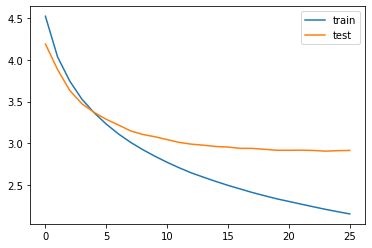

In [22]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [23]:
# 실제데이터 복원을위한 데이터셋 
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))
dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [24]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])
# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 
# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

단어 시퀀스를 완성을 위한 함수 생성

In [25]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [26]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i == 2): # End token
            break
        if (i!=0 and i != 1): # Exclude padding and start token
            temp = temp + tar_index_to_word[i] + ' '
    return temp

데이터 비교

In [27]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : actor ajay devgn took social media share first look upcoming film baadshaho caption alongside poster read film also stars emraan hashmi ileana cruz vidyut jammwal esha gupta directed milan action thriller scheduled release september 
실제 요약 : ajay devgn shares his first look from baadshaho 
예측 요약 :  ajay devgn shares first look of his st film


원문 : vaibhav year old cricketer mumbai died suffering heart attack field playing local cricket match continued bat team despite chest pain severe discomfort according reports died nearby hospital taken medical examination 
실제 요약 : yr old mumbai cricketer suffers heart attack while playing dies 
예측 요약 :  fan dies after being hit by football match in mumbai


원문 : world trade organization member countries agreed discuss new commerce framework member countries including india decided keep think time right country take multilateral obligations commerce rules government official reportedly said announcement start negotiations made world economic 

예측 요약 :  arrested for wearing pro pak cricket match in


원문 : spanish police seized kg cocaine hidden inside fire resistant bricks part two year investigation international drug smuggling operation run person identified grandmother estimated value cocaine million police also seized buildings vehicles raids 
실제 요약 : kg cocaine worth crore seized in spain 
예측 요약 :  kg of drugs seized in gujarat seized in gujarat


원문 : release date saif ali khan radhika apte chitrangda singh starrer announced october film also star rohan mehra son late actor vinod mehra directed chawla film set mumbai revolves around world stock trading 
실제 요약 : release date of saif radhika apte announced 
예측 요약 :  release date of saif ali khan announced


원문 : prime minister narendra modi responded congress vice president rahul gandhi vikas gone mad remark gujarat slogan vikas gujarat congress ran campaign vikas che slamming bjp promise development gujarat pm modi said rally chant hun vikas hun gujarat 
실제 요약 : pm modi 

예측 요약 :  andhra cm seeks probe on ex cm andhra cm arrest


원문 : many initial public offerings hit indian stock market year raising billion according report report said represents increase deal numbers compared notably largest ipo proceeds region general insurance corporation india worth billion 
실제 요약 : firms raised billion through in report 
예측 요약 :  misconduct of bn market value bn market cap hit by


원문 : pm narendra modi tuesday laid foundation stone thane kalyan metro mira metro corridors maharashtra pm modi also launched city industrial development corporation maharashtra mass housing scheme offers affordable homes pradhan mantri awas yojana mumbai thane helped nation realise dreams pm said 
실제 요약 : pm lays foundation stone of metro in maharashtra 
예측 요약 :  pm modi to launch mumbai metro train for mumbai


원문 : islamic state monday claimed responsibility attack police convoy egypt sinai peninsula attack killed police officials left seven others injured militants detonated improvi

In [28]:
## Summa을 이용해서 추출적 요약해보기

In [29]:
import requests
from summa.summarizer import summarize
# 테스트 데이터 다운로드 
#text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text
# 데이터 출력 
#print('Summary:')
#print(summarize(text, words=100))

print(encoder_input_test[50])
#print("원문 :", seq2text(encoder_input_test[50]))

[   50  1775  3676    74   155   110   368     7   518   182    15 13089
  1384  1392  1381   331    15     6   856  7540  7334  7393  6977 15374
 19384  6168  1816   243  6055   334  4517   404   218   403     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


## 회고
### 배운점
텍스트를 요약하기 위해 어텐션 메커니즘을 이용하여 추상적 추출을 하고 추출적 추출을 하는 방법을 배웠습니다. 
### 아쉬운점
완벽히 이해하지 못한것이 아쉽다.
### 느낀점
아직까지는 인코더 디코더 모델의 설계를 이해하지 못한 부분이 많고 다양한 공부를 통해 보충이 필요할것 같다.